In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
import albumentations
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
import nibabel as nib
from tqdm import tqdm
import pandas as pd

import skimage
from skimage import img_as_ubyte, img_as_float32

from sklearn.model_selection import StratifiedShuffleSplit

from glob import glob

np.random.seed(108)
 
plt.style.use('default')
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
visualize = False

In [2]:
class Config():
  ROOT = 'COVID'
  TRAIN_PATH = 'COVID'
  VAL_PATH = 'COVID'
  TEST_PATH = 'COVID'
  subset_data = 1000
  patch_dim = 9
  gap = 2
  batch_size = 64
  num_epochs = 50
  lr = 0.05

In [3]:
def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(10, 10))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

def show_plot(iteration,loss,fname):
    plt.plot(iteration,loss)
    plt.savefig(fname)
    plt.show()

In [4]:
"""
Args:
    tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
Returns:
    Tensor: Normalized image.
"""
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# unorm(tensor)

In [5]:
def convert_format(data, format):
  if format == 'p':
    return np.transpose(data, (0, 3, 1, 2))
  if format == 'n':
    return np.transpose(data, (0, 2, 3, 1))
  if format == '3':
    return np.transpose(data, (1, 2, 0))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [18]:
#############################
# Creating training dataset
#############################
df_list = [] 
classes = os.listdir(Config.TRAIN_PATH)
print(classes)
for idx, each_class in enumerate(classes):
  #print(idx)
  #print(each_class)
  images_in_each_class = glob(f'{Config.TRAIN_PATH}/{each_class}/images/*.png')
  #print(images_in_each_class)
  df_list += [[each_image, each_class] for each_image in images_in_each_class]

df = pd.DataFrame(data=df_list, columns=['filename', 'class'])

# Taking the classes subset
num_training_classes_subset = 4
train_classes_used = df['class'].unique()[:num_training_classes_subset]
df = df[df['class'].isin(train_classes_used)]
# df.groupby('class').count()
print(df.shape)

X, y = df['filename'], df['class']
ratio = Config.subset_data/len(X)
sss = StratifiedShuffleSplit(n_splits=5, train_size=ratio, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    stratified1000trn = train_index
    break

df_trn = df.iloc[stratified1000trn].reset_index(drop=True)
df_trn.head()

['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID']
(21225, 2)
StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=None,
            train_size=0.04711425206124853)
TRAIN: 1000 TEST: 20225


,filename,class
0,COVID/COVID/images/COVID-2795.png,COVID
1,COVID/Lung_Opacity/images/Lung_Opacity-2723.png,Lung_Opacity
2,COVID/COVID/images/COVID-2840.png,COVID
3,COVID/Lung_Opacity/images/Lung_Opacity-2966.png,Lung_Opacity
4,COVID/COVID/images/COVID-933.png,COVID


In [19]:
#############################
# Creating validation dataset
#############################
df_list = [] 
classes = os.listdir(Config.VAL_PATH)
print(classes)
for idx, each_class in enumerate(classes):
  #print(idx)
  #print(each_class)
  images_in_each_class = glob(f'{Config.VAL_PATH}/{each_class}/images/*.png')
  #print(images_in_each_class)
  df_list += [[each_image, each_class] for each_image in images_in_each_class]

print(len(df_list))
df = pd.DataFrame(data=df_list, columns=['filename', 'class'])
print(df.shape)
# Using only those classes in the dataset which are used in the training
df = df[df['class'].isin(train_classes_used)]
print(df.shape)

X, y = df['filename'], df['class']
sss = StratifiedShuffleSplit(n_splits=5, train_size=0.2, random_state=0)
sss.get_n_splits(X, y)

print(sss)
print(X)
print(y)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    stratified1000val = train_index
    break

df_val = df.iloc[stratified1000val].reset_index(drop=True)
df_val['filename'] = '' + df_val['filename']
df_val[['filename', 'class']].head()

['Lung_Opacity', 'Viral Pneumonia', 'Normal', 'COVID']
21225
(21225, 2)
(21225, 2)
StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=None,
            train_size=0.2)
0        COVID/Lung_Opacity/images/Lung_Opacity-5856.png
1        COVID/Lung_Opacity/images/Lung_Opacity-5855.png
2          COVID/Lung_Opacity/images/Lung_Opacity-55.png
3        COVID/Lung_Opacity/images/Lung_Opacity-5927.png
4        COVID/Lung_Opacity/images/Lung_Opacity-5828.png
                              ...                       
21220                  COVID/COVID/images/COVID-1812.png
21221                  COVID/COVID/images/COVID-1690.png
21222                  COVID/COVID/images/COVID-1507.png
21223                  COVID/COVID/images/COVID-1722.png
21224                  COVID/COVID/images/COVID-1475.png
Name: filename, Length: 21225, dtype: object
0        Lung_Opacity
1        Lung_Opacity
2        Lung_Opacity
3        Lung_Opacity
4        Lung_Opacity
             ...     
21220           CO

,filename,class
0,COVID/Viral Pneumonia/images/Viral Pneumonia-1...,Viral Pneumonia
1,COVID/Lung_Opacity/images/Lung_Opacity-3467.png,Lung_Opacity
2,COVID/Lung_Opacity/images/Lung_Opacity-4349.png,Lung_Opacity
3,COVID/COVID/images/COVID-2840.png,COVID
4,COVID/COVID/images/COVID-1927.png,COVID


In [20]:
class MyDataset(Dataset):
  def __init__(self, patch_dim, gap, df, validate, transform=None):
    self.patch_dim, self.gap = patch_dim, gap
    self.transform = transform

    if validate:
      self.train_data = df.values
    else:
      self.train_data = df.values
  
  def get_patch_from_grid(self, image, patch_dim, gap):
    image = np.array(image)

    offset_x, offset_y = image.shape[0] - (patch_dim*3 + gap*2), image.shape[1] - (patch_dim*3 + gap*2)
    start_grid_x, start_grid_y = np.random.randint(0, offset_x), np.random.randint(0, offset_y)
    patch_loc_arr = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (3, 3)]
    loc = np.random.randint(len(patch_loc_arr))
    tempx, tempy = patch_loc_arr[loc]
    
    patch_x_pt = start_grid_x + patch_dim * (tempx-1) + gap * (tempx-1)
    patch_y_pt = start_grid_y + patch_dim * (tempy-1) + gap * (tempy-1)
    random_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]

    patch_x_pt = start_grid_x + patch_dim * (2-1) + gap * (2-1)
    patch_y_pt = start_grid_y + patch_dim * (2-1) + gap * (2-1)
    uniform_patch = image[patch_x_pt:patch_x_pt+patch_dim, patch_y_pt:patch_y_pt+patch_dim]
    
    random_patch_label = loc
    
    return uniform_patch, random_patch, random_patch_label

  def __len__(self):
    return len(self.train_data)
  
  def __getitem__(self, index):
    image = Image.open(self.train_data[index]).convert('RGB')
    uniform_patch, random_patch, random_patch_label = self.get_patch_from_grid(image, 
                                                                               self.patch_dim, 
                                                                               self.gap)
    if uniform_patch.shape[0] != 96:
        uniform_patch = skimage.transform.resize(uniform_patch, (96, 96))
        random_patch = skimage.transform.resize(random_patch, (96, 96))
        
        uniform_patch = img_as_float32(uniform_patch)
        random_patch = img_as_float32(random_patch)

    # Dropped color channels 2 and 3 and replaced with gaussian noise(std ~1/100 of the std of the remaining channel)
    #uniform_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #uniform_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
    #random_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))
    #random_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))

    random_patch_label = np.array(random_patch_label).astype(np.int64)
        
    if self.transform:
      uniform_patch = self.transform(uniform_patch)
      random_patch = self.transform(random_patch)

    return uniform_patch, random_patch, random_patch_label



##################################################
# Creating Train/Validation dataset and dataloader
##################################################

traindataset = MyDataset(Config.patch_dim, Config.gap, df_trn['filename'], False,
                         transforms.Compose([transforms.ToTensor(),
                                             ]))
trainloader = torch.utils.data.DataLoader(traindataset, 
                                          batch_size=Config.batch_size,
                                          shuffle=True,
                                          # num_workers=Config.num_workers
                                          )


valdataset = MyDataset(Config.patch_dim, Config.gap, df_val['filename'], True,
                         transforms.Compose([transforms.ToTensor(),
                                             ]))
valloader = torch.utils.data.DataLoader(valdataset,
                                        batch_size=Config.batch_size,
                                        shuffle=False)

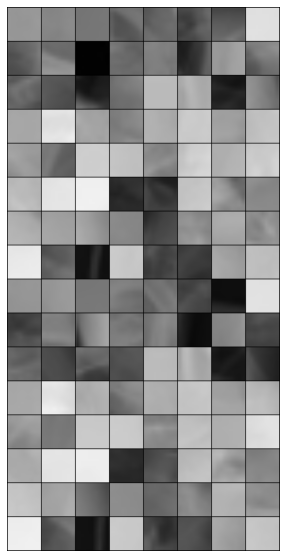

Labels: [3 2 6 0 6 3 2 6 5 1 4 7 3 7 3 6 3 4 5 5 1 1 6 7 6 4 7 6 1 6 6 2 3 5 0 0 1
 0 1 4 0 6 4 3 3 1 5 1 5 4 4 3 7 4 2 3 6 1 1 1 4 5 6 3]


In [21]:
##############################
# Visualizing training dataset
##############################

example_batch = next(iter(trainloader))
concatenated = torch.cat((unorm(example_batch[0]),unorm(example_batch[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch[2].numpy()}')

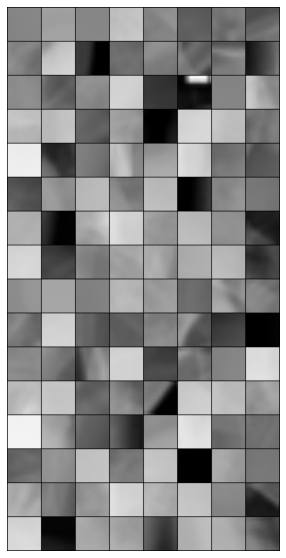

Labels: [2 6 0 0 4 0 5 5 6 4 0 5 5 1 1 0 0 1 5 1 6 6 5 5 4 2 3 1 1 1 6 7 7 3 2 4 3
 6 1 2 6 7 7 4 3 0 0 3 4 3 6 1 5 6 5 1 3 1 3 3 7 2 1 6]


In [22]:
##############################
# Visualizing validation dataset
##############################

example_batch_val = next(iter(valloader))
concatenated = torch.cat((unorm(example_batch_val[0]),unorm(example_batch_val[1])),0)
imshow(torchvision.utils.make_grid(concatenated))
print(f'Labels: {example_batch_val[2].numpy()}')

In [23]:
class AlexNetwork(nn.Module):
  def __init__(self,aux_logits = False):
      super(AlexNetwork, self).__init__()
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride = 2,padding = 2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2,padding = 1),
      )
      self.fc6 = nn.Sequential(
        nn.Linear(256,4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096),
      )
      self.fc = nn.Sequential(
        nn.Linear(2*4096,4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output


  def forward(self, uniform_patch, random_patch):
    output_fc6_uniform = self.forward_once(uniform_patch)
    output_fc6_random = self.forward_once(random_patch)
    output = torch.cat((output_fc6_uniform,output_fc6_random), 1)
    output = self.fc(output)
    return output, output_fc6_uniform, output_fc6_random

model = AlexNetwork().to(device)

In [24]:
#############################################
# Initialized Optimizer, criterion, scheduler
#############################################

if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=5,
                                           factor=0.3, verbose=True)

In [25]:
############################
# Training/Validation Engine
############################

global_trn_loss = []
global_val_loss = []
# previous_val_loss = 100

for epoch in range(Config.num_epochs):
    train_running_loss = []
    val_running_loss = []
    start_time = time.time()
    model.train()
    for idx, data in tqdm(enumerate(trainloader), total=int(len(traindataset)/Config.batch_size)):
        uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
        loss = criterion(output, random_patch_label)
        loss.backward()
        optimizer.step()
        
        train_running_loss.append(loss.item())
    else:
      correct = 0
      total = 0
      model.eval()
      with torch.no_grad():
        for idx, data in tqdm(enumerate(valloader), total=int(len(valdataset)/Config.batch_size)):
          uniform_patch, random_patch, random_patch_label = data[0].to(device), data[1].to(device), data[2].to(device)
          output, output_fc6_uniform, output_fc6_random = model(uniform_patch, random_patch)
          loss = criterion(output, random_patch_label)
          val_running_loss.append(loss.item())
        
          _, predicted = torch.max(output.data, 1)
          total += random_patch_label.size(0)
          correct += (predicted == random_patch_label).sum()
        print('Val Progress --- total:{}, correct:{}'.format(total, correct.item()))
        print('Val Accuracy of the network on the 10000 test images: {}%'.format(100 * correct / total))

    global_trn_loss.append(sum(train_running_loss) / len(train_running_loss))
    global_val_loss.append(sum(val_running_loss) / len(val_running_loss))

    scheduler.step(global_val_loss[-1])

    print('Epoch [{}/{}], TRNLoss:{:.4f}, VALLoss:{:.4f}, Time:{:.2f}'.format(
        epoch + 1, Config.num_epochs, global_trn_loss[-1], global_val_loss[-1],
        (time.time() - start_time) / 60))
    
    if epoch % 5 == 0:
      MODEL_SAVE_PATH = f'/content/drive/My Drive/{Config.batch_size}_{Config.num_epochs}_{Config.lr}_{Config.subset_data}_{Config.patch_dim}_{Config.gap}.pt'
      torch.save(
        {
            'epoch': Config.num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'global_trnloss': global_trn_loss,
            'global_valloss': global_val_loss
        }, MODEL_SAVE_PATH)
      #drive.mount('/content/drive', force_remount=True)

16it [03:23, 12.70s/it]
67it [11:14, 10.07s/it]


Val Progress --- total:4245, correct:530
Val Accuracy of the network on the 10000 test images: 12.48527717590332%
Epoch [1/50], TRNLoss:15588.8394, VALLoss:131727.4887, Time:14.64


16it [00:18,  1.17s/it]
67it [00:54,  1.22it/s]


Val Progress --- total:4245, correct:511
Val Accuracy of the network on the 10000 test images: 12.037692070007324%
Epoch [2/50], TRNLoss:2.1365, VALLoss:531.5967, Time:1.23


16it [00:15,  1.01it/s]
67it [00:54,  1.23it/s]


Val Progress --- total:4245, correct:542
Val Accuracy of the network on the 10000 test images: 12.767962455749512%
Epoch [3/50], TRNLoss:2.1480, VALLoss:2.1005, Time:1.18


16it [00:15,  1.00it/s]
67it [00:54,  1.24it/s]


Val Progress --- total:4245, correct:518
Val Accuracy of the network on the 10000 test images: 12.202591896057129%
Epoch [4/50], TRNLoss:2.1233, VALLoss:1360.3115, Time:1.17


16it [00:15,  1.02it/s]
67it [00:54,  1.22it/s]


Val Progress --- total:4245, correct:558
Val Accuracy of the network on the 10000 test images: 13.144876480102539%
Epoch [5/50], TRNLoss:2.1230, VALLoss:44870896.4759, Time:1.18


16it [00:15,  1.01it/s]
67it [00:54,  1.22it/s]


Val Progress --- total:4245, correct:577
Val Accuracy of the network on the 10000 test images: 13.592461585998535%
Epoch [6/50], TRNLoss:2.1356, VALLoss:3887603338.8952, Time:1.18


16it [00:19,  1.21s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:528
Val Accuracy of the network on the 10000 test images: 12.438162803649902%
Epoch [7/50], TRNLoss:2.1146, VALLoss:148033627.6008, Time:1.24


16it [00:15,  1.01it/s]
67it [00:54,  1.22it/s]


Val Progress --- total:4245, correct:541
Val Accuracy of the network on the 10000 test images: 12.744405746459961%
Epoch [8/50], TRNLoss:2.1094, VALLoss:76463050.9212, Time:1.18


16it [00:16,  1.00s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:527
Val Accuracy of the network on the 10000 test images: 12.414605140686035%
Epoch     9: reducing learning rate of group 0 to 1.5000e-02.
Epoch [9/50], TRNLoss:2.1182, VALLoss:177156538.8395, Time:1.19


16it [00:16,  1.01s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:559
Val Accuracy of the network on the 10000 test images: 13.16843318939209%
Epoch [10/50], TRNLoss:2.0936, VALLoss:337961146.2503, Time:1.20


16it [00:16,  1.02s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:533
Val Accuracy of the network on the 10000 test images: 12.555948257446289%
Epoch [11/50], TRNLoss:2.0898, VALLoss:5366385.0382, Time:1.20


16it [00:18,  1.18s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:493
Val Accuracy of the network on the 10000 test images: 11.613663673400879%
Epoch [12/50], TRNLoss:2.0947, VALLoss:58454937.9302, Time:1.24


16it [00:16,  1.02s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:551
Val Accuracy of the network on the 10000 test images: 12.979976654052734%
Epoch [13/50], TRNLoss:2.0881, VALLoss:1999619216.1374, Time:1.20


16it [00:15,  1.00it/s]
67it [00:56,  1.19it/s]


Val Progress --- total:4245, correct:579
Val Accuracy of the network on the 10000 test images: 13.639575958251953%
Epoch [14/50], TRNLoss:2.0835, VALLoss:117274024.8353, Time:1.20


16it [00:16,  1.02s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:550
Val Accuracy of the network on the 10000 test images: 12.956419944763184%
Epoch    15: reducing learning rate of group 0 to 4.5000e-03.
Epoch [15/50], TRNLoss:2.0881, VALLoss:10283478.5880, Time:1.20


16it [00:16,  1.01s/it]
67it [00:56,  1.19it/s]


Val Progress --- total:4245, correct:545
Val Accuracy of the network on the 10000 test images: 12.83863353729248%
Epoch [16/50], TRNLoss:2.0803, VALLoss:80871561.0081, Time:1.21


16it [00:18,  1.18s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:533
Val Accuracy of the network on the 10000 test images: 12.555948257446289%
Epoch [17/50], TRNLoss:2.0824, VALLoss:179180553.6989, Time:1.25


16it [00:16,  1.02s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:561
Val Accuracy of the network on the 10000 test images: 13.215547561645508%
Epoch [18/50], TRNLoss:2.0822, VALLoss:1232584324.6287, Time:1.20


16it [00:16,  1.03s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:534
Val Accuracy of the network on the 10000 test images: 12.579505920410156%
Epoch [19/50], TRNLoss:2.0799, VALLoss:1402316767.2705, Time:1.20


16it [00:16,  1.00s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:523
Val Accuracy of the network on the 10000 test images: 12.320377349853516%
Epoch [20/50], TRNLoss:2.0796, VALLoss:180686704.6878, Time:1.20


16it [00:16,  1.01s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:536
Val Accuracy of the network on the 10000 test images: 12.626619338989258%
Epoch    21: reducing learning rate of group 0 to 1.3500e-03.
Epoch [21/50], TRNLoss:2.0797, VALLoss:590626056.4918, Time:1.20


16it [00:19,  1.21s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:506
Val Accuracy of the network on the 10000 test images: 11.919905662536621%
Epoch [22/50], TRNLoss:2.0822, VALLoss:713230735.5845, Time:1.25


16it [00:16,  1.02s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:546
Val Accuracy of the network on the 10000 test images: 12.862191200256348%
Epoch [23/50], TRNLoss:2.0825, VALLoss:208135890.3846, Time:1.20


16it [00:16,  1.02s/it]
67it [00:59,  1.13it/s]


Val Progress --- total:4245, correct:526
Val Accuracy of the network on the 10000 test images: 12.391048431396484%
Epoch [24/50], TRNLoss:2.0801, VALLoss:646071894.4519, Time:1.26


16it [00:16,  1.01s/it]
67it [00:57,  1.16it/s]


Val Progress --- total:4245, correct:533
Val Accuracy of the network on the 10000 test images: 12.555948257446289%
Epoch [25/50], TRNLoss:2.0804, VALLoss:158969749.8392, Time:1.24


16it [00:16,  1.03s/it]
67it [00:56,  1.19it/s]


Val Progress --- total:4245, correct:536
Val Accuracy of the network on the 10000 test images: 12.626619338989258%
Epoch [26/50], TRNLoss:2.0816, VALLoss:1812981777.3343, Time:1.21


16it [00:19,  1.19s/it]
67it [00:56,  1.20it/s]


Val Progress --- total:4245, correct:521
Val Accuracy of the network on the 10000 test images: 12.273262977600098%
Epoch    27: reducing learning rate of group 0 to 4.0500e-04.
Epoch [27/50], TRNLoss:2.0818, VALLoss:803366721.4310, Time:1.25


16it [00:16,  1.05s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:538
Val Accuracy of the network on the 10000 test images: 12.673733711242676%
Epoch [28/50], TRNLoss:2.5469, VALLoss:5305749075.8718, Time:1.20


16it [00:16,  1.00s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:531
Val Accuracy of the network on the 10000 test images: 12.508833885192871%
Epoch [29/50], TRNLoss:2.0799, VALLoss:72347770.1564, Time:1.20


16it [00:16,  1.01s/it]
67it [00:54,  1.23it/s]


Val Progress --- total:4245, correct:548
Val Accuracy of the network on the 10000 test images: 12.909305572509766%
Epoch [30/50], TRNLoss:2.0800, VALLoss:617912540.8880, Time:1.18


16it [00:15,  1.01it/s]
67it [00:55,  1.22it/s]


Val Progress --- total:4245, correct:531
Val Accuracy of the network on the 10000 test images: 12.508833885192871%
Epoch [31/50], TRNLoss:2.0793, VALLoss:130591753.4785, Time:1.18


16it [00:18,  1.18s/it]
67it [00:53,  1.25it/s]


Val Progress --- total:4245, correct:531
Val Accuracy of the network on the 10000 test images: 12.508833885192871%
Epoch [32/50], TRNLoss:2.0815, VALLoss:51310010.4615, Time:1.21


16it [00:15,  1.01it/s]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:532
Val Accuracy of the network on the 10000 test images: 12.532391548156738%
Epoch    33: reducing learning rate of group 0 to 1.2150e-04.
Epoch [33/50], TRNLoss:2.0799, VALLoss:5163494698.0651, Time:1.19


16it [00:16,  1.01s/it]
67it [00:54,  1.22it/s]


Val Progress --- total:4245, correct:540
Val Accuracy of the network on the 10000 test images: 12.720848083496094%
Epoch [34/50], TRNLoss:2.0794, VALLoss:1622758412.9778, Time:1.19


16it [00:16,  1.01s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:529
Val Accuracy of the network on the 10000 test images: 12.461719512939453%
Epoch [35/50], TRNLoss:2.0799, VALLoss:165242004.2779, Time:1.20


16it [00:16,  1.02s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:533
Val Accuracy of the network on the 10000 test images: 12.555948257446289%
Epoch [36/50], TRNLoss:2.0795, VALLoss:2824258111.1757, Time:1.20


16it [00:19,  1.24s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:517
Val Accuracy of the network on the 10000 test images: 12.179034233093262%
Epoch [37/50], TRNLoss:2.0797, VALLoss:309032530.0342, Time:1.26


16it [00:16,  1.00s/it]
67it [00:54,  1.22it/s]


Val Progress --- total:4245, correct:537
Val Accuracy of the network on the 10000 test images: 12.650177001953125%
Epoch [38/50], TRNLoss:2.0795, VALLoss:5562551.3349, Time:1.18


16it [00:16,  1.00s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:534
Val Accuracy of the network on the 10000 test images: 12.579505920410156%
Epoch    39: reducing learning rate of group 0 to 3.6450e-05.
Epoch [39/50], TRNLoss:2.0792, VALLoss:308958030.2366, Time:1.20


16it [00:15,  1.00it/s]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:544
Val Accuracy of the network on the 10000 test images: 12.81507682800293%
Epoch [40/50], TRNLoss:2.0794, VALLoss:455398701.2809, Time:1.19


16it [00:16,  1.01s/it]
67it [00:55,  1.21it/s]


Val Progress --- total:4245, correct:499
Val Accuracy of the network on the 10000 test images: 11.755005836486816%
Epoch [41/50], TRNLoss:2.0791, VALLoss:14575208.6297, Time:1.19


16it [00:18,  1.16s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:527
Val Accuracy of the network on the 10000 test images: 12.414605140686035%
Epoch [42/50], TRNLoss:2.0793, VALLoss:1251359012.7656, Time:1.24


16it [00:16,  1.02s/it]
67it [00:54,  1.23it/s]


Val Progress --- total:4245, correct:555
Val Accuracy of the network on the 10000 test images: 13.07420539855957%
Epoch [43/50], TRNLoss:2.0790, VALLoss:83916207.9350, Time:1.18


16it [00:16,  1.01s/it]
67it [00:56,  1.18it/s]


Val Progress --- total:4245, correct:509
Val Accuracy of the network on the 10000 test images: 11.990577697753906%
Epoch [44/50], TRNLoss:2.0800, VALLoss:59606302.8936, Time:1.21


16it [00:17,  1.07s/it]
67it [00:55,  1.20it/s]


Val Progress --- total:4245, correct:541
Val Accuracy of the network on the 10000 test images: 12.744405746459961%
Epoch    45: reducing learning rate of group 0 to 1.0935e-05.
Epoch [45/50], TRNLoss:2.0793, VALLoss:692581881.8035, Time:1.22


16it [00:16,  1.01s/it]
67it [00:56,  1.18it/s]


Val Progress --- total:4245, correct:478
Val Accuracy of the network on the 10000 test images: 11.260306358337402%
Epoch [46/50], TRNLoss:2.0792, VALLoss:453792982.6081, Time:1.22


16it [00:19,  1.25s/it]
67it [00:56,  1.18it/s]


Val Progress --- total:4245, correct:586
Val Accuracy of the network on the 10000 test images: 13.804475784301758%
Epoch [47/50], TRNLoss:2.0796, VALLoss:956027398.8184, Time:1.28


16it [00:16,  1.04s/it]
67it [00:57,  1.17it/s]


Val Progress --- total:4245, correct:534
Val Accuracy of the network on the 10000 test images: 12.579505920410156%
Epoch [48/50], TRNLoss:2.0789, VALLoss:30364813.9789, Time:1.23


16it [00:16,  1.03s/it]
67it [00:56,  1.19it/s]


Val Progress --- total:4245, correct:537
Val Accuracy of the network on the 10000 test images: 12.650177001953125%
Epoch [49/50], TRNLoss:2.0798, VALLoss:2541160891.3278, Time:1.22


16it [00:16,  1.03s/it]
67it [00:57,  1.17it/s]

Val Progress --- total:4245, correct:528
Val Accuracy of the network on the 10000 test images: 12.438162803649902%
Epoch [50/50], TRNLoss:2.0791, VALLoss:1537842405.0893, Time:1.23
